
# <span style="color:rgb(213,80,0)">exercise2\_dct\_compression\_board.m</span>

Exercise 2 – Image Compression using 2‑D DCT on board.png


Steps:


1) Split the image into non‑overlapping 32×32 blocks


2) Apply 2‑D DCT (dct2) to each block


3) Keep a percentage r of DCT coefficients using:


&nbsp;&nbsp;&nbsp;&nbsp; (a) Zone method (low‑frequency radial mask)


&nbsp;&nbsp;&nbsp;&nbsp; (b) Threshold method (keep largest‑magnitude coeffs)


4) Reconstruct with inverse DCT (idct2)


5) Compute MSE between original and reconstructed image


6) Plot MSE vs r for r = 5…50 %


Author: ANGELOS NIKOLAOS POTAMIANOS Date: MAY 2025


In [1]:
clear; close all; clc;

## \-\-\-\-\-\-\-\-\-\- Parameters \-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-

In [2]:
image_path = fullfile('Images','Ασκηση 2','board.png');  %% adjust if needed
blockSize   = [32 32];
rList       = 5:5:50;        %% percentages to test
save_plot   = true;
plot_path   = 'dct_mse_board.png';
save_images = true;          %% save reconstructed images for r=10%
vis_blocks  = true;          %% visualize DCT coefficients for a sample block

## \-\-\-\-\-\-\-\-\-\-\-Read & convert to grayscale double in \[0,255\]

In [3]:
disp('Loading and preprocessing image...');

Loading and preprocessing image...


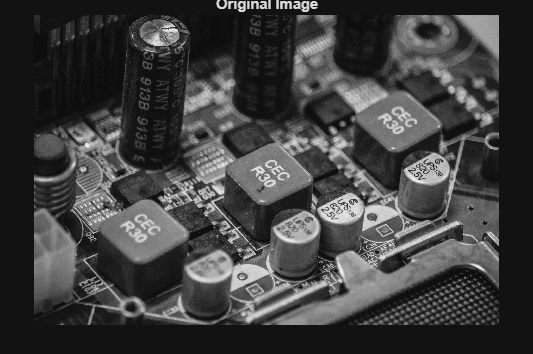

In [4]:
I = imread(image_path);
if size(I,3) == 3
    I = rgb2gray(I);
end
I = double(I);

% Display original image
figure('Name', 'Original Image');
imshow(uint8(I));
title('Original Image');

In [5]:
fprintf('Image dimensions: %d x %d pixels\n', size(I,1), size(I,2));

Image dimensions: 1500 x 2250 pixels

## Pad image so that dimensions are multiples of 32

In [6]:
[M,N] = size(I);
padM = mod(-M, blockSize(1));   %% additional rows
padN = mod(-N, blockSize(2));   %% additional cols
Ipad = padarray(I, [padM padN], 'replicate', 'post');
[Mpad,Npad] = size(Ipad);
fprintf('Padded to: %d x %d pixels\n', Mpad, Npad);

Padded to: 1504 x 2272 pixels

## Pre‑compute block indices

In [7]:
nBlocksRow = Mpad / blockSize(1);
nBlocksCol = Npad / blockSize(2);
fprintf('Image divided into %d x %d blocks of size %d x %d\n', ...
    nBlocksRow, nBlocksCol, blockSize(1), blockSize(2));

Image divided into 47 x 71 blocks of size 32 x 32

In [8]:

% Total number of coefficients per block
totalCoeffs = prod(blockSize);
fprintf('Total coefficients per block: %d\n', totalCoeffs);

Total coefficients per block: 1024

## Prepare result arrays

In [9]:
mse_zone      = zeros(size(rList));
mse_threshold = zeros(size(rList));
psnr_zone     = zeros(size(rList));
psnr_threshold = zeros(size(rList));
cr_zone       = zeros(size(rList));  % Compression ratio
cr_threshold  = zeros(size(rList));

% Prepare to save images at r=10%
save_idx = find(rList == 10);
if isempty(save_idx)
    save_idx = 2; % Default to second value if 10% not in list
end

## \-\-\-\-\-\-\-\-\-\- Main loop over r values \-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-

In [10]:
fprintf('\nProcessing compression with different r values...\n');

Processing compression with different r values...

In [11]:
fprintf('-----------------------------------------------\n');

-----------------------------------------------

In [12]:
fprintf('%-5s | %-12s | %-12s | %-12s | %-12s\n', ...
    'r(%)', 'MSE Zone', 'MSE Threshold', 'PSNR Zone', 'PSNR Threshold');

r(%)  | MSE Zone     | MSE Threshold | PSNR Zone    | PSNR Threshold

In [13]:
fprintf('-----------------------------------------------\n');

-----------------------------------------------

In [14]:

for rIdx = 1:numel(rList)
    r = rList(rIdx);
    keepFrac = r / 100;
    nkeep = round(keepFrac * totalCoeffs);   %% coeffs to preserve

    % Calculate theoretical compression ratio
    compression_ratio = totalCoeffs / nkeep;

    % Start timer
    tic;

    rec_zone      = zeros(Mpad, Npad);
    rec_thresh    = zeros(Mpad, Npad);

    % Sample block for visualization
    sample_br = floor(nBlocksRow/2);
    sample_bc = floor(nBlocksCol/2);

    for br = 1:nBlocksRow
        for bc = 1:nBlocksCol
            rowRange = (br-1)*blockSize(1)+1 : br*blockSize(1);
            colRange = (bc-1)*blockSize(2)+1 : bc*blockSize(2);
            block = Ipad(rowRange, colRange);


## 2‑D DCT

In [15]:
            C = dct2(block);


## Visualize DCT coefficients for a sample block

In [16]:
            if vis_blocks && br == sample_br && bc == sample_bc && rIdx == 1
                figure('Name', 'DCT Coefficient Visualization');

                % Original block
                subplot(2,3,1);
                imshow(uint8(block));
                title('Sample 32x32 Block');

                % DCT coefficients (log scale)
                subplot(2,3,2);
                imshow(log(abs(C)+1), []);
                title('DCT Coefficients (log scale)');

                % Store for later visualization of masks
                sample_C = C;
            end


## \-\-\-\-\- (a) ZONE METHOD \-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-


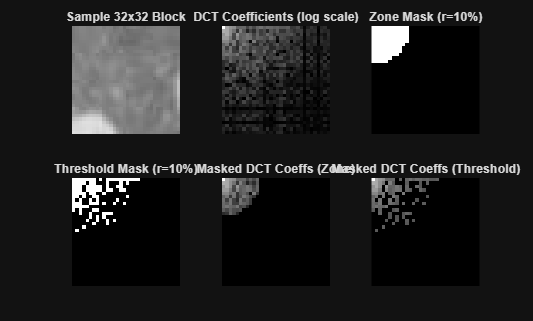

In [17]:
            [u,v] = meshgrid(0:blockSize(2)-1, 0:blockSize(1)-1);
            D = sqrt(u.^2 + v.^2);
            Dvec = sort(D(:),'ascend');
            radiusThr = Dvec(nkeep);
            mask_zone = double(D <= radiusThr);
            Cz = C .* mask_zone;
            block_rec_zone = idct2(Cz);

            % Visualize zone method for sample block
            if vis_blocks && br == sample_br && bc == sample_bc && rIdx == save_idx
                % Zone mask
                subplot(2,3,3);
                imshow(mask_zone, []);
                title(sprintf('Zone Mask (r=%d%%)', r));

                % Masked DCT coefficients
                subplot(2,3,5);
                imshow(log(abs(Cz)+1), []);
                title('Masked DCT Coeffs (Zone)');
            end


## \-\-\-\-\- (b) THRESHOLD METHOD \-\-\-\-\-\-\-\-\-\-\-\-\-\-\-

In [18]:
            [~, idxSort] = sort(abs(C(:)), 'descend');
            mask_thresh = zeros(blockSize);
            mask_thresh(idxSort(1:nkeep)) = 1;
            Ct = C .* mask_thresh;
            block_rec_thresh = idct2(Ct);

            % Visualize threshold method for sample block
            if vis_blocks && br == sample_br && bc == sample_bc && rIdx == save_idx
                % Threshold mask
                subplot(2,3,4);
                imshow(mask_thresh, []);
                title(sprintf('Threshold Mask (r=%d%%)', r));

                % Masked DCT coefficients
                subplot(2,3,6);
                imshow(log(abs(Ct)+1), []);
                title('Masked DCT Coeffs (Threshold)');
            end


## Place reconstructed blocks

In [19]:
            rec_zone(rowRange, colRange)   = block_rec_zone;
            rec_thresh(rowRange, colRange) = block_rec_thresh;
        end
    end

    % Processing time
    proc_time = toc;


## Crop back to original size

In [20]:
    rec_zone   = rec_zone(1:M, 1:N);
    rec_thresh = rec_thresh(1:M, 1:N);


## Compute MSE and PSNR

In [21]:
    mse_zone(rIdx)      = mean((I(:) - rec_zone(:)).^2);
    mse_threshold(rIdx) = mean((I(:) - rec_thresh(:)).^2);

    % PSNR calculation
    max_val = 255;
    psnr_zone(rIdx)     = 10 * log10(max_val^2 / mse_zone(rIdx));
    psnr_threshold(rIdx) = 10 * log10(max_val^2 / mse_threshold(rIdx));

    % Store compression ratios
    cr_zone(rIdx) = compression_ratio;
    cr_threshold(rIdx) = compression_ratio;

    fprintf('%-5d | %-12.3f | %-12.3f | %-12.3f | %-12.3f\n', ...
        r, mse_zone(rIdx), mse_threshold(rIdx), psnr_zone(rIdx), psnr_threshold(rIdx));


5     | 28.799       | 17.003       | 33.537       | 35.825      
10    | 15.600       | 8.449        | 36.200       | 38.863      
15    | 10.908       | 5.011        | 37.753       | 41.131      
20    | 7.999        | 3.201        | 39.101       | 43.078      
25    | 5.665        | 2.112        | 40.599       | 44.884      
30    | 4.112        | 1.417        | 41.991       | 46.617      
35    | 2.991        | 0.955        | 43.372       | 48.329      
40    | 2.199        | 0.636        | 44.709       | 50.098      
45    | 1.654        | 0.421        | 45.946       | 51.890      
50    | 1.329        | 0.273        | 46.896       | 53.770

## Visualize reconstructed images for specific r value


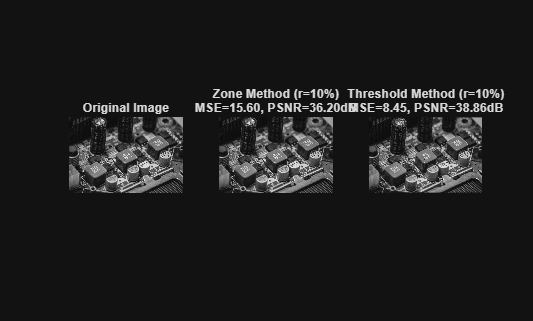

Saved reconstructed images for r=10%

In [22]:
    if rIdx == save_idx
        figure('Name', sprintf('Compression Results (r=%d%%)', r));

        % Original
        subplot(1,3,1);
        imshow(uint8(I));
        title('Original Image');

        % Zone method reconstruction
        subplot(1,3,2);
        imshow(uint8(rec_zone));
        title(sprintf('Zone Method (r=%d%%)\nMSE=%.2f, PSNR=%.2fdB', ...
            r, mse_zone(rIdx), psnr_zone(rIdx)));

        % Threshold method reconstruction
        subplot(1,3,3);
        imshow(uint8(rec_thresh));
        title(sprintf('Threshold Method (r=%d%%)\nMSE=%.2f, PSNR=%.2fdB', ...
            r, mse_threshold(rIdx), psnr_threshold(rIdx)));

        % Save reconstructed images if requested
        if save_images
            imwrite(uint8(rec_zone), sprintf('board_zone_r%d.png', r));
            imwrite(uint8(rec_thresh), sprintf('board_threshold_r%d.png', r));
            fprintf('Saved reconstructed images for r=%d%%\n', r);
        end
    end
end

## Compute and display compression efficiency metrics

In [23]:
fprintf('\nCompression Efficiency Metrics:\n');

Compression Efficiency Metrics:

In [24]:
fprintf('-----------------------------------------------\n');

-----------------------------------------------

In [25]:
fprintf('%-5s | %-12s | %-12s | %-12s | %-12s\n', ...
    'r(%)', 'CR Zone', 'CR Threshold', 'Bits/pix Zone', 'Bits/pix Thresh');

r(%)  | CR Zone      | CR Threshold | Bits/pix Zone | Bits/pix Thresh

In [26]:
fprintf('-----------------------------------------------\n');

-----------------------------------------------

In [27]:

for rIdx = 1:numel(rList)
    r = rList(rIdx);
    bits_per_pixel_zone = 8 / cr_zone(rIdx);  % assuming 8-bit per pixel orig
    bits_per_pixel_threshold = 8 / cr_threshold(rIdx);

    fprintf('%-5d | %-12.2f | %-12.2f | %-12.2f | %-12.2f\n', ...
        r, cr_zone(rIdx), cr_threshold(rIdx), ...
        bits_per_pixel_zone, bits_per_pixel_threshold);
end

5     | 20.08        | 20.08        | 0.40         | 0.40        
10    | 10.04        | 10.04        | 0.80         | 0.80        
15    | 6.65         | 6.65         | 1.20         | 1.20        
20    | 5.00         | 5.00         | 1.60         | 1.60        
25    | 4.00         | 4.00         | 2.00         | 2.00        
30    | 3.34         | 3.34         | 2.40         | 2.40        
35    | 2.86         | 2.86         | 2.80         | 2.80        
40    | 2.50         | 2.50         | 3.20         | 3.20        
45    | 2.22         | 2.22         | 3.60         | 3.60        
50    | 2.00         | 2.00         | 4.00         | 4.00

## \-\-\-\-\-\-\-\- Plot MSE curves \-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\-

In [28]:
figure('Name', 'Compression Performance');

% MSE plot
subplot(2,2,1);
plot(rList, mse_zone, '-o', 'LineWidth',1.2); hold on;
plot(rList, mse_threshold, '-s', 'LineWidth',1.2);
xlabel('Percentage of kept DCT coefficients r (%)');
ylabel('Mean Squared Error (MSE)');
title('MSE vs. Compression Ratio');
legend('Zone method', 'Threshold method', 'Location','northeast');
grid on;

% PSNR plot
subplot(2,2,2);
plot(rList, psnr_zone, '-o', 'LineWidth',1.2); hold on;
plot(rList, psnr_threshold, '-s', 'LineWidth',1.2);
xlabel('Percentage of kept DCT coefficients r (%)');
ylabel('PSNR (dB)');
title('PSNR vs. Compression Ratio');
legend('Zone method', 'Threshold method', 'Location','southeast');
grid on;

% Compression ratio plot
subplot(2,2,3);
plot(rList, cr_zone, '-o', 'LineWidth',1.2); hold on;
plot(rList, cr_threshold, '-s', 'LineWidth',1.2);
xlabel('Percentage of kept DCT coefficients r (%)');
ylabel('Compression Ratio');
title('Compression Ratio vs. r');
legend('Zone method', 'Threshold method', 'Location','northeast');
grid on;

% Bits per pixel plot
subplot(2,2,4);
plot(rList, 8./cr_zone, '-o', 'LineWidth',1.2); hold on;
plot(rList, 8./cr_threshold, '-s', 'LineWidth',1.2);
xlabel('Percentage of kept DCT coefficients r (%)');
ylabel('Bits per Pixel');
title('Bits per Pixel vs. r');
legend('Zone method', 'Threshold method', 'Location','northeast');
grid on;

% Adjust figure size and layout
set(gcf, 'Position', [100, 100, 1000, 800]);

if save_plot
    saveas(gcf, plot_path);
    fprintf('\nPlot saved to %s\n', plot_path);
end

Plot saved to dct_mse_board.png

In [29]:

fprintf('\nCompression analysis complete!\n');

Compression analysis complete!